# Project 1

Mama mia, here we go again (with classification)...

## Imports 

In [1]:
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
sns.set_style('darkgrid')

print(f"Python version: {sys.version}.")

Python version: 3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ].


## Loading Data

In [2]:
df_train = pd.read_csv("./Data_train.csv")

In [3]:
df_train.head()

,Unnamed: 0,x,y,class
0,0,9.478938,-4.950071,1
1,1,-8.476344,3.635107,3
2,2,4.080771,-3.684994,3
3,3,-0.509729,-5.700655,2
4,4,-0.898476,-4.007790,3


In [4]:
df_train = df_train.drop("Unnamed: 0", axis='columns')
df_train.head()

,x,y,class
0,9.478938,-4.950071,1
1,-8.476344,3.635107,3
2,4.080771,-3.684994,3
3,-0.509729,-5.700655,2
4,-0.898476,-4.007790,3


In [5]:
X_train, y_train = df_train[["x", "y"]].values, df_train["class"].values

In [6]:
y_train.shape

(5625,)

Let's do the same for the test data:

In [7]:
df_test = pd.read_csv("./Data_test.csv").drop("Unnamed: 0", axis='columns')
df_test.head()

,x,y,class
0,2.597513,-1.720239,1
1,7.951270,6.252087,2
2,-6.913355,4.858647,3
3,-2.948122,-0.585784,3
4,0.865727,-3.874243,3


In [8]:
X_test, y_test = df_test[["x", "y"]].values, df_test["class"].values

## Task 0: Naive Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

Let's also do a quick visualization to verify we have nonlinear data:

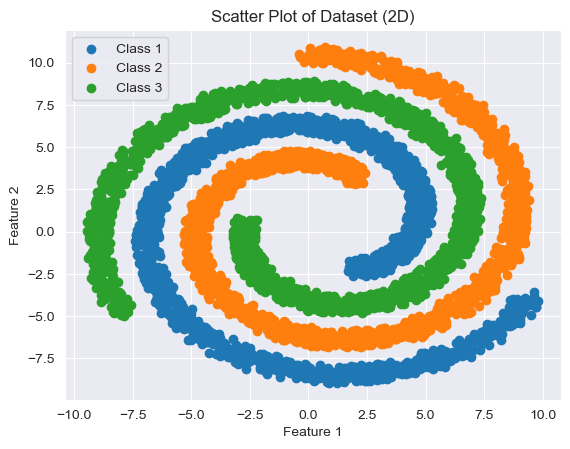

In [10]:
class1, class2, class3 = (
    df_train[df_train["class"] == 1][["x", "y"]],
    df_train[df_train["class"] == 2][["x", "y"]],
    df_train[df_train["class"] == 3][["x", "y"]],
)

plt.scatter(class1["x"], class1["y"], label='Class 1')
plt.scatter(class2["x"], class2["y"], label='Class 2')
plt.scatter(class3["x"], class3["y"], label='Class 3')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Dataset (2D)")
plt.legend()
plt.show()

Intriguing!
Okay, so by this plot we need to make sure our model can handle multinomial problems. The args I'm passing below are the defaults, but I just to be explicit about the type of model being created (and further description can be found on the `sklearn` [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

/var/folders/n0/3kqw7k395kb6swksbngs7zw40000gn/T/ipykernel_56035/444656601.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


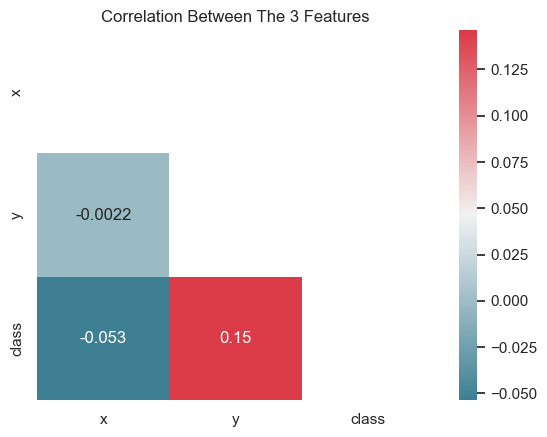

In [11]:
# Credit to the Seaborn Documentation for inspiring this cell: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")
# Compute the correlation matrix
corr = df_train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)
plt.title('Correlation Between The 3 Features')
plt.show()

The other good sign for this dataset is (as we can see above) there is low multicolinearity between the different features. This should be helpful to us, as that is one of the assumptions of linear classifiers.

In [62]:
def evaluate_log_reg(X_train, y_train, X_test,
                    y_test, kernel_type=''):
    model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{kernel_type} Logisitic Regression Accuracy: {round(accuracy * 100, 4)}%.")
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.show()
    return model

Naive Logisitic Regression Accuracy: 34.7733%.


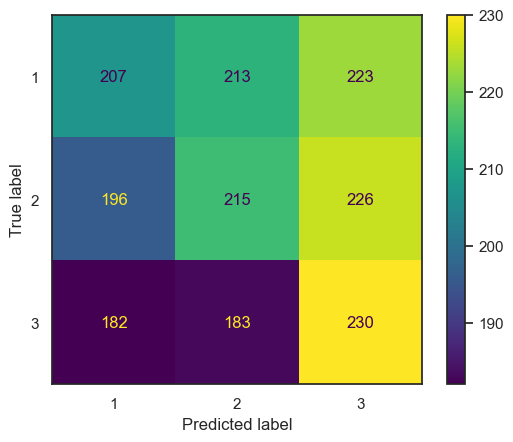

In [64]:
naive_model = evaluate_log_reg(X_train, y_train,
                                X_test, y_test, 
                                kernel_type='Naive')

Accuracy is only ~34% (not great).

## Task 1: Train Data Transformation

### Kernel 0: Scaling

This isn't actually taking the dataset into a new feature space - I just wanted to make sure that as a first step in our preprocessed, I included the code to normalize our data to be Gaussian:

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Kernel 1: Quadratic

**Justification**:
- it is straightforward enough to implement, which makes it a good pick for our first kernel.

**Mathematical Expansion**:

 $$k(x,y)=<x,y>^2=<x^2,\sqrt{2}xy,y^2>$$

Now let's take a crack at doing this in the code:

In [15]:
def quadratic_feature_mapping(x, y):
    """Assume both x and y are column vectors of shape (n, 1)."""
    x_1d = np.squeeze(x)
    y_1d = np.squeeze(y)

    feat1 = x_1d ** 2
    feat2 = np.sqrt(2) * x_1d * y_1d
    feat3 = y_1d ** 2
   			
    return np.column_stack([feat1, feat2, feat3])

In [16]:
quadratic_X_train = quadratic_feature_mapping(
    # x and y are passed here as args, respectively
    X_train_scaled[:, 0], X_train_scaled[:, 1],
)

quadratic_X_test = quadratic_feature_mapping(
    X_test_scaled[:, 0], X_test_scaled[:, 1],  # x & y, respectively
)

Well! We've transformed the data, but how do we know whether or not this will lead to a better logistic regression model?

Let's go ahead and validate the assumptions of logistic regression. We begin by writing some dependency code:

In [17]:
import numbers

from sklearn import _loss as L
from sklearn.linear_model import TweedieRegressor
from sklearn.utils import validation

class MyHalfTweedieLoss(L.loss.HalfTweedieLoss):
    def __init__(self, *args, **kwargs):
        self.link=L.link.LogitLink()  # key distinction from what's in Sklearn out of the box
        super().__init__(*args, **kwargs)

class MyTweedieRegressor(TweedieRegressor):
    """
    We'll use this for a plot later,
    when checking one of the assumptions in Scikit-learn.
    """
    def _get_loss(self):
        '''
        we might need to use this because Scikit-learn only came
        with the option to use a 'log' or 'identity' link func

        otherwise, I think it's just a cool concept of a class to write
        '''
        if self.link == 'logit':
            return MyHalfTweedieLoss(power=self.power)

In [18]:
# sanity check
m3 = MyTweedieRegressor(link='logit', power=0)
m3.fit(X_train_scaled, y_train)
m3.score(X_test_scaled, y_test)

0.0168103250818451

In [19]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

In [58]:
def check_assumptions(X_train, y_train, X_test, is_time_series=False):
    """
    These checks are based on the blog post by Kenneth Leung,
    "Assumptions of Logistic Regression, Clearly Explained" (2021), on Medium.com:
    https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290
    """
    ### Assumption 1: Distinct Categories for the Outcome var:
    num_classes = np.unique(y_train).shape[0]
    if num_classes > 1:
        print("Assumption 1 passes: this dataset has >= 2 classes")
    else:
        raise RuntimeWarning("Assumption 1 fails: dataset has < 2 classes")

    ### Assumption 2: Linearity of independent variables and log-odds ###
    # I used GLM below rather than MyTweedieRegressor, as it handles invalid values better
    # the point of this code is to visually check
    print(f"For the next {X_train.shape[1]} charts, check to see if they are all linear")
    for num_feature in range(X_train.shape[1]):
        logit_results = GLM(y_train, X_train[:, num_feature], family=families.Binomial()).fit()
        predicted = logit_results.predict(X_test[:, num_feature].reshape(-1, 1))

        # Getting log odds values
        log_odds = np.log(predicted / (1 - predicted))
        # in case of division by 0, we replace with "max_int" - just some really high value
        max_int = 500_000
        log_odds = np.where(log_odds == np.inf, max_int, log_odds)

        # Visualize predictor variable vs logit values for the target
        plt.scatter(x=X_test[:, num_feature], y=log_odds)
        plt.xlabel(f"Feature {num_feature + 1}")
        plt.ylabel("Log-odds")
        plt.show()

    ### Assumption 3: Check for Outliers - SKIPPED, since we visually saw above
    # in the first scatter plot that there are none

    ### Assumption 4: Absence of multicolinearity - SKIPPED, since we visually
    # since we visually saw in the heatmap that the correlation between features is low

    ### Assumption 5: Independence of Assumptions
    if not is_time_series:
        print("B/c this is not a time series dataset, auto-assume that observations are independent.")
    else:
        # TODO: there are still ways to check, but that's outside the scope of this project
        raise RuntimeWarning("You have time series, and I'm not sure how to check it\
            to make sure your samples are independent (yet).")

    ### Assumption 6: Sufficiently large sample size
    is_large_enough = X_train.shape[0] > 500
    if is_large_enough:
        print(f"This dataset is large enough to work - {X_train.shape[0]}")
    else:
        raise RuntimeWarning(f"Assumption 6 fails because there are only \
            {X_train.shape[0]} samples, less than 500")
    

#### Confirming Assumptions on SCALED Dataset

To verify this, let's make a new scatter plot between each feature and the target column.
We'll start by doing this on the scaled dataset.

Although it's preprocessed, this dataset will have the same characteristics as our input dataset - so this next cell gives us a bit of a baseline:

Assumption 1 passes: this dataset has >= 2 classes
For the next 2 charts, check to see if they are all linear


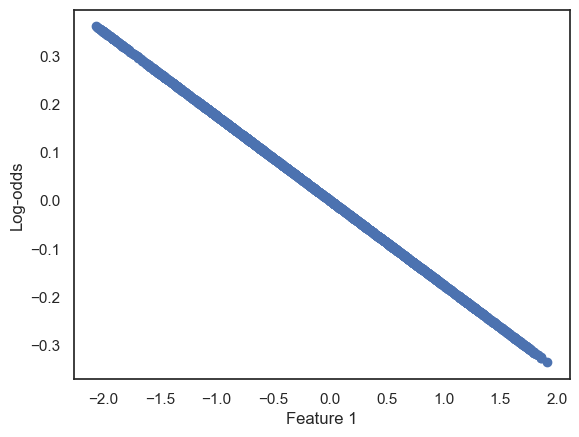

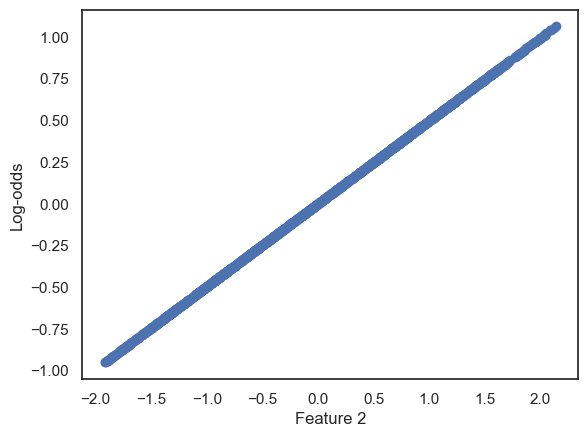

B/c this is not a time series dataset, auto-assume that observations are independent.
This dataset is large enough to work - 5625


In [59]:
# sanity check
check_assumptions(X_train_scaled, y_train, X_test_scaled, is_time_series=False)

**Conclusion**: as we can see, our input dataset already meets about all the different assumptions for logistic regression. Let's see if the same is true for our dataset, that was transformed using the quadratic kernel:

Assumption 1 passes: this dataset has >= 2 classes
For the next 3 charts, check to see if they are all linear


/var/folders/n0/3kqw7k395kb6swksbngs7zw40000gn/T/ipykernel_56035/1185260472.py:25: RuntimeWarning: divide by zero encountered in true_divide
  log_odds = np.log(predicted / (1 - predicted))


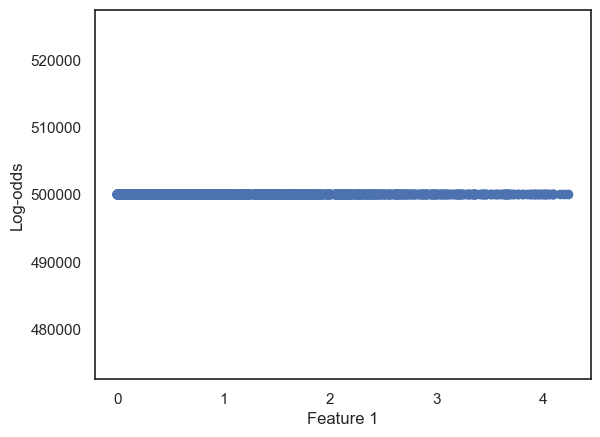

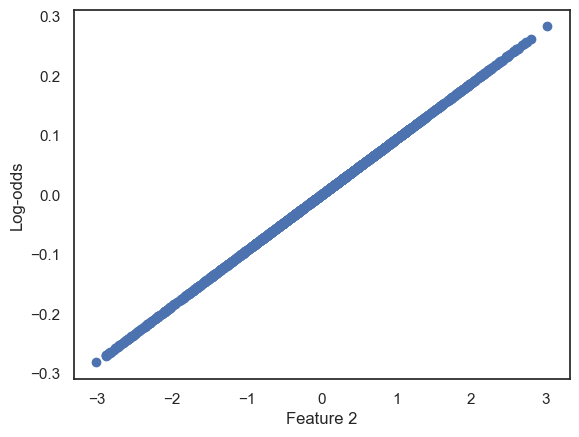

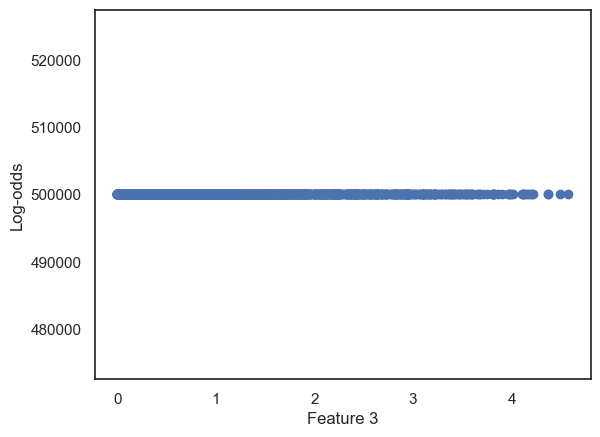

B/c this is not a time series dataset, auto-assume that observations are independent.
This dataset is large enough to work - 5625


In [60]:
check_assumptions(quadratic_X_train, y_train, quadratic_X_test, is_time_series=False)

**Conclusion**:
The quadratic kernel also passes all the assumptions of logistic regression (technically speaking).

As we can see from the scatter plots outputted by the previous cell, the relationship between the independent features and the logits of the target is linear (even though when I computed the log-odds for the first and third features, it encountered an error in dividing by zero).

## Task 2: Linear Parametric Classification



*"Make a logistic regression model. Report the weights and the accuracy of the model."* - let's do it, using our dataset transformed using the quadratic kernel!

Quadratic Logisitic Regression Accuracy: 36.6933%.


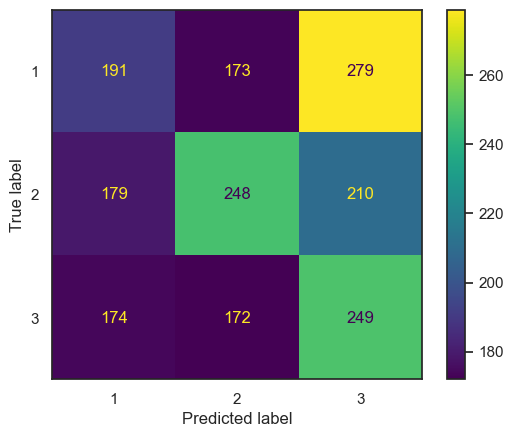

In [65]:
quad_model = evaluate_log_reg(quadratic_X_train, y_train,
                                quadratic_X_test, y_test,
                                kernel_type='Quadratic')

What are the weights?

In [69]:
print(f"Weights of logistic regression (quadratic kernel):\n{quad_model.coef_}.")
print(f"Bias of logistic regression (quadratic kernel):\n{quad_model.intercept_}.")

Weights of logistic regression (quadratic kernel):
[[-0.07200043 -0.11603807  0.08733188]
 [-0.03177326  0.15057988  0.04016272]
 [ 0.10377369 -0.03454181 -0.12749461]].
Bias of logistic regression (quadratic kernel):
[-0.02514202 -0.01336062  0.03850264].


#### Hyperparameter Tuning via `GridSearchCV`

You already knew this was coming up:

*Using the GridSearchCV at various 100  values from 10-5 to 105, build a logistic regression model. Visualize how the model accuracy behaves. Then report the best model. If the accuracy is 100%, then the model is overfitted. In this case, the model should be regularized.*


In [70]:
from sklearn.model_selection import GridSearchCV

In [106]:
def grid_search_and_visualize(X_train, y_train, X_test, y_test, kernel_type=''):
    """
    Given training data in some kernel,
    we will tune the hyperparameters for a logreg via grid search, 
    visualize the behavior of the accuracy, 
    and evaluate the best model on the test data. 
    """

    # A: Define parameter grid
    c_values = np.linspace(10e-5, 10e5, 100)
    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

    # B: Do the hyperparameter tuning
    parameters = {'C': c_values, 'solver': solvers}
    new_model = LogisticRegression(penalty='l2', random_state=42)
    tuned_model = GridSearchCV(new_model, parameters, cv=5)
    tuned_model.fit(X_train, y_train)

    # C: Visualize the results
    df_results = pd.DataFrame(tuned_model.cv_results_)
    for solver in solvers:
        scores = df_results[df_results['param_solver'] == solver][['param_C', 'mean_test_score']]
        plt.plot(scores['param_C'], scores['mean_test_score'], label=solver)
    plt.legend()
    plt.ylabel("Avg. Accuracy on the 5 Folds")
    plt.xlabel("Inverse of Regularization Strength (C)")
    plt.title(f"Results of Grid Search for Logistic Regression ({kernel_type} Kernel)")
    plt.show()

    print(f"Best accuracy found: {round(df_results['mean_test_score'].max() * 100, 4)}%.")

    # D: Evaluate the model on the test data
    best_model = tuned_model.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)
    print(f"Evaluation of Best {kernel_type} Model: {round(test_accuracy * 100, 4)}%.")
    return best_model


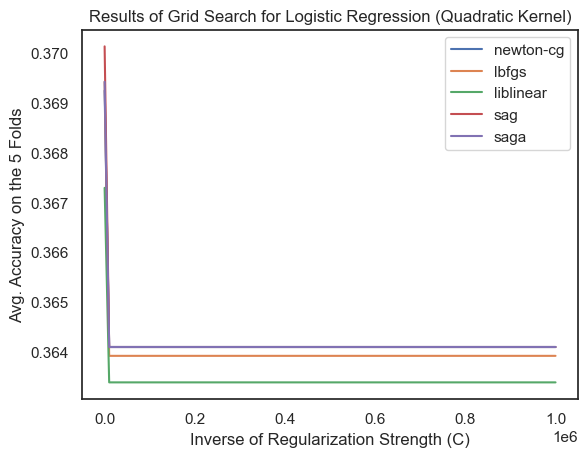

Best accuracy found: 37.0133%.
Evaluation of Best Quadratic Model: 35.84%.


In [107]:
best_quadratic_model = grid_search_and_visualize(
    quadratic_X_train, y_train,
    quadratic_X_test, y_test, 
    kernel_type='Quadratic'
)

Ok! So we are seeing the best model trained using our quadratic kernel is showing a mean accuracy of about 37%, which is a marginal improvement over our naive model at the start.

Can we take a look at the exact hyperparameters this model had? And what was it's mean accuracy on the data it was tested with?

In [108]:
best_quadratic_model

LogisticRegression(C=0.0001, random_state=42, solver='sag')

## Task 3: Transformation using Kernel Method
Goal: we want to Kernelize the original to a Kernel space using 5 different valid Kernel functions mentioned in Bishop. 

Note: since I've already used the quadratic kernel above, the code below will start counting from the *second* to the fifth kernel function.

### Kernel 2: Cubic Polynomial

[![TODO: include this pic in report](https://i.postimg.cc/s2HTWq1Z/IMG-3600.png)](https://postimg.cc/zLWwZdCJ)

**Justification**:
- it is straightforward enough to implement, and will be more complex which might be helpful in building a better model (because right now our issue is underfitting, since we have low train/test accuracy)

**Mathematical Expansion**:

 $$k(x,y)=<x,y>^3=<x^3, \sqrt{3}x^2y, \sqrt{3}xy^2, y^3>$$

Let's see it in code:

In [103]:
def cubic_feature_mapping(x, y):
    """Assume both x and y are column vectors of shape (n, 1)."""
    x = np.squeeze(x)
    y = np.squeeze(y)
   			
    return np.column_stack([
        x ** 3,
        np.sqrt(3) * (x ** 2) * y,
        np.sqrt(3) * x * (y ** 2),
        y ** 3
    ])

In [109]:
cubic_X_train = cubic_feature_mapping(
    # x and y are passed here as args, respectively
    X_train_scaled[:, 0], X_train_scaled[:, 1],
)

cubic_X_test = cubic_feature_mapping(
    X_test_scaled[:, 0], X_test_scaled[:, 1],  # x & y, respectively
)

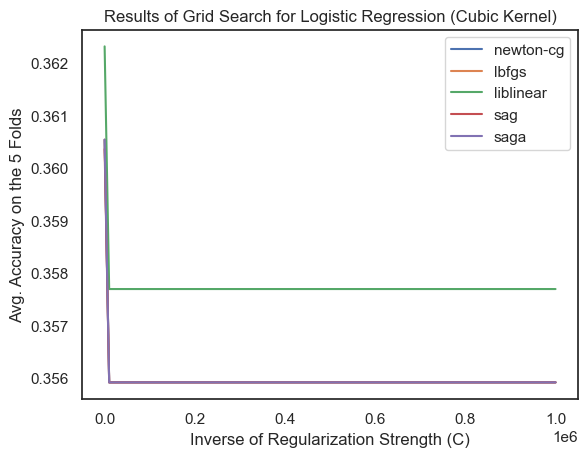

Best accuracy found: 36.2311%.
Evaluation of Best Cubic Model: 34.8267%.


In [110]:
best_cubic_model = grid_search_and_visualize(
    cubic_X_train, y_train,
    cubic_X_test, y_test, 
    kernel_type='Cubic'
)

In [112]:
best_cubic_model  # displays the hyperparameters

LogisticRegression(C=0.0001, random_state=42, solver='liblinear')

### Kernel 3: "Exponential-Quadratic" Kernel

I made up the name - I'm going to construct it simply by taking our quadratic from before, and exponentiating it:

In [124]:
def exp_feature_mapping(x, y):
    """Assume both x and y are column vectors of shape (n, 1)."""   			
    return np.exp(quadratic_feature_mapping(x, y))

In [125]:
exp_X_train = exp_feature_mapping(
    # x and y are passed here as args, respectively
    X_train_scaled[:, 0], X_train_scaled[:, 1],
)

exp_X_test = exp_feature_mapping(
    X_test_scaled[:, 0], X_test_scaled[:, 1],  # x & y, respectively
)

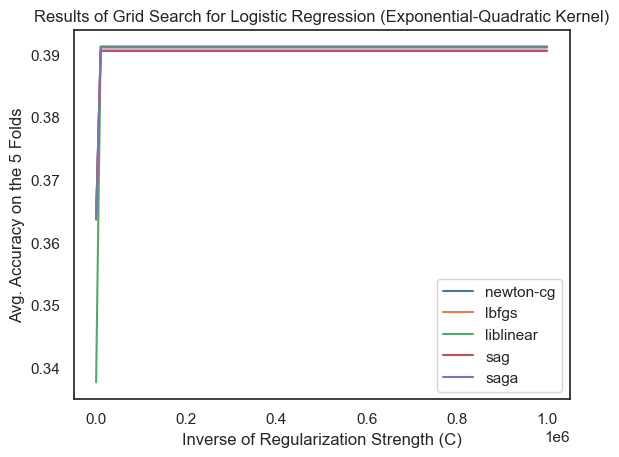

Best accuracy found: 39.1289%.
Evaluation of Best Exponential-Quadratic Model: 41.5467%.


In [142]:
best_exp_model = grid_search_and_visualize(
    exp_X_train, y_train,
    exp_X_test, y_test, 
    kernel_type='Exponential-Quadratic'
)

### Kernel 4: The "Sum" Kernel

Since the quadratic and exponential kernels seemed to be underfitting, I figured why not see if the accuracy would improve by adding both into one:

In [131]:
def sum_feature_mapping(x, y):
    """Assume both x and y are column vectors of shape (n, 1)."""   			
    return exp_feature_mapping(x, y) + quadratic_feature_mapping(x, y)

In [133]:
sum_X_train = sum_feature_mapping(
    # x and y are passed here as args, respectively
    X_train_scaled[:, 0], X_train_scaled[:, 1],
)

sum_X_test = sum_feature_mapping(
    X_test_scaled[:, 0], X_test_scaled[:, 1],  # x & y, respectively
)

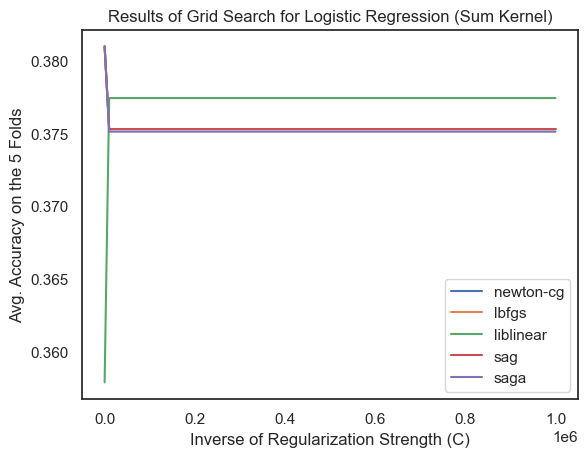

Best accuracy found: 38.0978%.
Evaluation of Best Sum Model: 40.1067%.


In [134]:
best_sum_model = grid_search_and_visualize(
    sum_X_train, y_train,
    sum_X_test, y_test, 
    kernel_type='Sum'
)

### Kernel 5: The "Hyperbolic Tangent" Kernel

For the last kernel I'll try, I'm curious to see the affect of using the `tanh()` function on one of our previous kernels:

In [143]:
def tanh_feature_mapping(x, y):
    return np.tanh(exp_feature_mapping(x, y))

In [144]:
tanh_X_train = tanh_feature_mapping(
    # x and y are passed here as args, respectively
    X_train_scaled[:, 0], X_train_scaled[:, 1],
)

tanh_X_test = tanh_feature_mapping(
    X_test_scaled[:, 0], X_test_scaled[:, 1],  # x & y, respectively
)

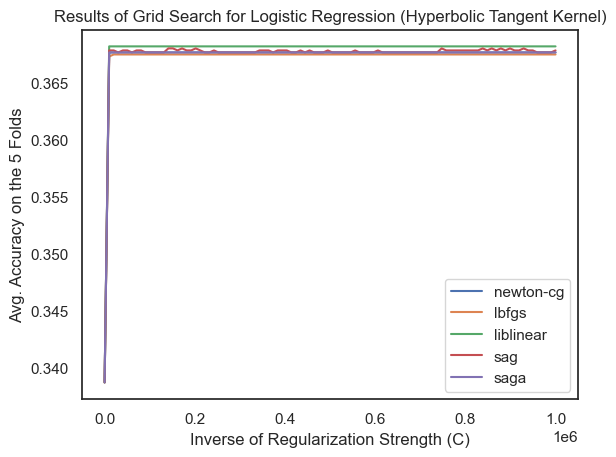

Best accuracy found: 36.8178%.
Evaluation of Best Hyperbolic Tangent Model: 36.64%.


In [145]:
best_tanh_model = grid_search_and_visualize(
    tanh_X_train, y_train,
    tanh_X_test, y_test, 
    kernel_type='Hyperbolic Tangent'
)

## SCRAP
Ignore everthing below.

In [113]:
from sklearn.gaussian_process.kernels import RBF

In [116]:
rbf_X_train = RBF(1.0)(X_train_scaled)
rbf_X_test = RBF(1.0)(X_test_scaled)

3. Gaussian
4. probabilistic generative
5. Fisher

Quadratic Kernel Logisitic Regression Accuracy: 36.6933%.


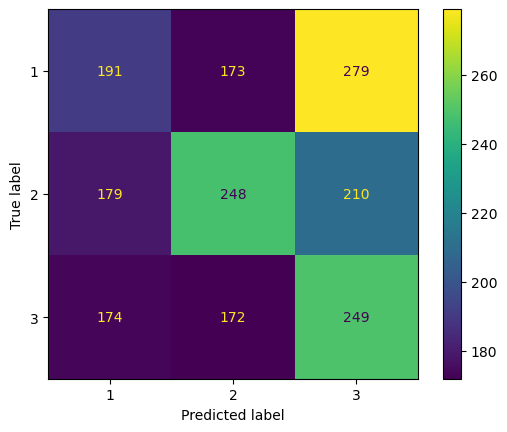

In [73]:
evaluate_log_reg(quadratic_X_train, y_train,
                quadratic_X_test, y_test,
                kernel_type='Quadratic Kernel')

### Natural Log

Maybe we can make the dataset linear using the natural log?

In [67]:
df_train_transformed = df_train.copy()
df_train["ln_y"] = np.log(df_train["x"].values)

/var/folders/n0/3kqw7k395kb6swksbngs7zw40000gn/T/ipykernel_14474/855529085.py:2: RuntimeWarning: invalid value encountered in log
  df_train["ln_y"] = np.log(df_train["x"].values)


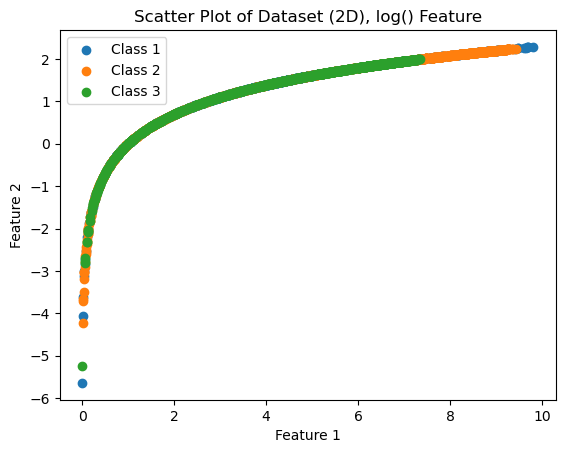

In [104]:
class1, class2, class3 = (
    df_train_transformed[df_train["class"] == 1][["x", "ln_y"]],
    df_train_transformed[df_train["class"] == 2][["x", "ln_y"]],
    df_train_transformed[df_train["class"] == 3][["x", "ln_y"]],
)

plt.scatter(class1["x"], class1["ln_y"], label='Class 1')
plt.scatter(class2["x"], class2["ln_y"], label='Class 2')
plt.scatter(class3["x"], class3["ln_y"], label='Class 3')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Dataset (2D), log() Feature")
plt.legend()
plt.show()

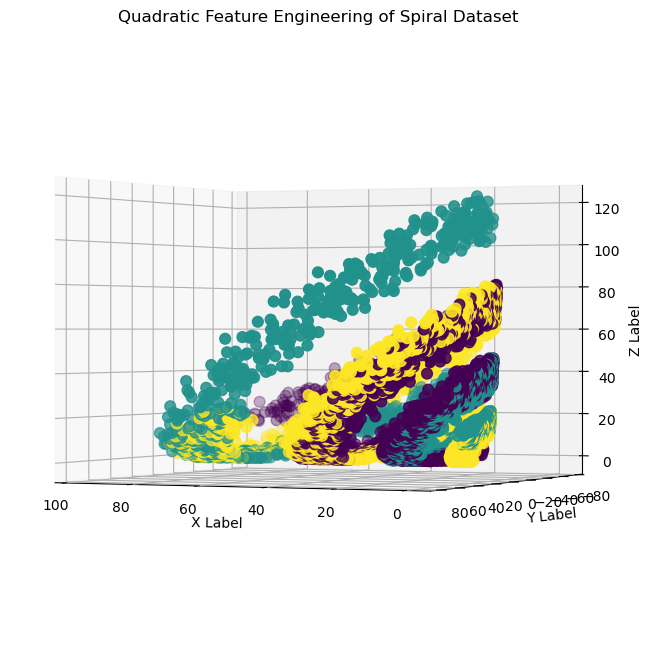

In [103]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(quadratic_X_train[:, 0],
           quadratic_X_train[:, 1],
           quadratic_X_train[:, 2],
           c=np.squeeze(df_train["class"].values), s=60)
ax.view_init(0, 115)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("Quadratic Feature Engineering of Spiral Dataset")
plt.show()

### RBF

The quadratic mapping didn't seem to do much better. How about RBF?

I will be using the formulation of RBF kernel provided from [[1]](https://www.youtube.com/watch?v=Q0ExqOphnW0), found on YouTube.

In [83]:
def rbf_feature_mapping(x, y):
    rbf_feat = (
        -0.5 * (np.linalg.norm(x - y) ** 2)
    )   
    trans_x = np.array([x, y, rbf_feat])				
    return trans_x

In [98]:
rbf_X_train = quadratic_feature_mapping(
    np.squeeze(X_train["x"].values),
    np.squeeze(X_train["y"].values),
)

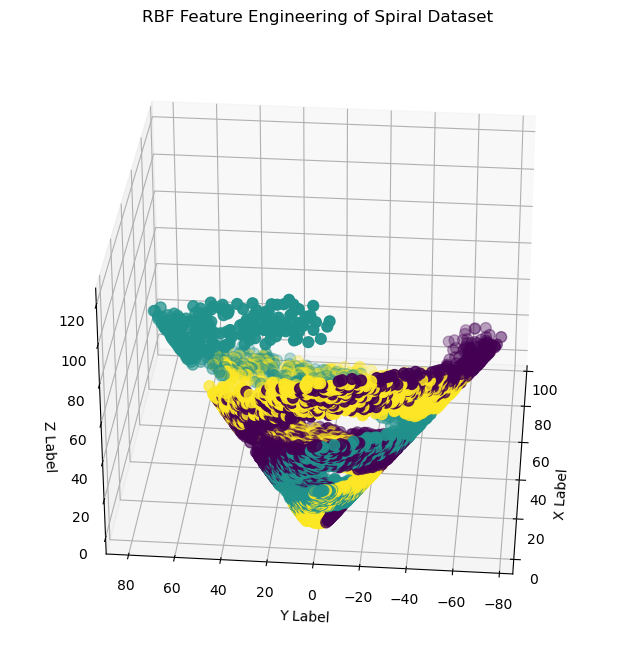

In [102]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rbf_X_train[0, :],
           rbf_X_train[1, :],
           rbf_X_train[2, :],
           c=np.squeeze(df_train["class"].values), s=60)
ax.view_init(30, 185)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("RBF Feature Engineering of Spiral Dataset")
plt.show()